In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS03-012.h5"

In [3]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [4]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (9822837, 4)
X_s shape: (9822837, 14)
X_v shape: (9822837, 14)
T shape: (9822837, 10)
A shape: (9822837, 4)


In [5]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


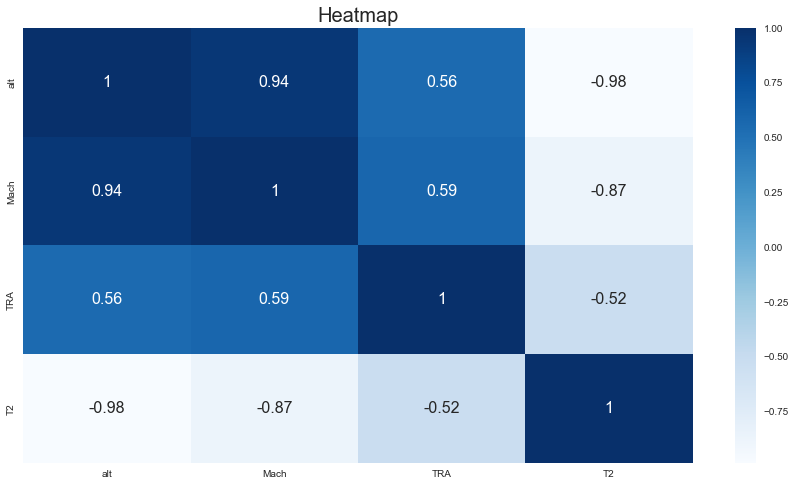

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [7]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s['cycle'] = df_A['cycle'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle
0,623.266249,1504.144560,1922.440193,1306.504494,19.479848,14.016458,19.776495,24.906112,424.243432,430.769311,16.372809,2231.317258,8798.762277,5.170440,1.0,3009.0,0.307251,81.122467,517.529644,1.0
1,623.273965,1504.122771,1922.406132,1306.446755,19.478941,14.016341,19.775574,24.905223,424.192372,430.717632,16.368839,2231.311771,8798.681998,5.169749,1.0,3018.0,0.308007,81.122467,517.544010,1.0
2,623.264954,1504.080473,1922.296550,1306.334637,19.475765,14.014077,19.772350,24.901653,424.109039,430.633829,16.364000,2231.332391,8798.559586,5.168377,1.0,3027.0,0.308385,81.122467,517.535333,1.0
3,623.276143,1504.062861,1922.273378,1306.284192,19.475312,14.014359,19.771890,24.901320,424.064473,430.588673,16.360203,2231.325322,8798.489387,5.167803,1.0,3036.0,0.309204,81.122467,517.553822,1.0
4,623.275162,1504.030231,1922.171879,1306.170158,19.472962,14.012781,19.769505,24.898888,423.993039,430.517024,16.355370,2231.359781,8798.396354,5.166576,1.0,3045.0,0.309708,81.122467,517.553077,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9822832,564.032527,1252.602278,1489.215204,1138.059248,15.873627,13.635329,16.115358,18.086485,219.421038,223.981222,14.202211,1572.079376,7955.597019,2.093787,15.0,3024.0,0.235242,25.224430,513.507091,67.0
9822833,564.042008,1252.630863,1489.259242,1138.104433,15.875488,13.636726,16.117246,18.088550,219.452258,224.013019,14.204803,1572.089891,7955.692325,2.094142,15.0,3019.0,0.234990,25.224430,513.512854,67.0
9822834,564.038260,1252.642836,1489.272112,1138.139857,15.876008,13.636677,16.117775,18.089062,219.472313,224.033412,14.207577,1572.085264,7955.738558,2.094332,15.0,3013.0,0.234297,25.224430,513.501906,67.0
9822835,564.051309,1252.680370,1489.365478,1138.221796,15.878384,13.638634,16.120187,18.091608,219.510612,224.072094,14.210332,1572.078714,7955.850430,2.094874,15.0,3008.0,0.234171,25.224430,513.513709,67.0


In [ ]:
df_X_s.info(memory_usage="deep")

In [8]:
#selezione unita e ciclo
unit=1
cycle=10

<Figure size 432x288 with 0 Axes>

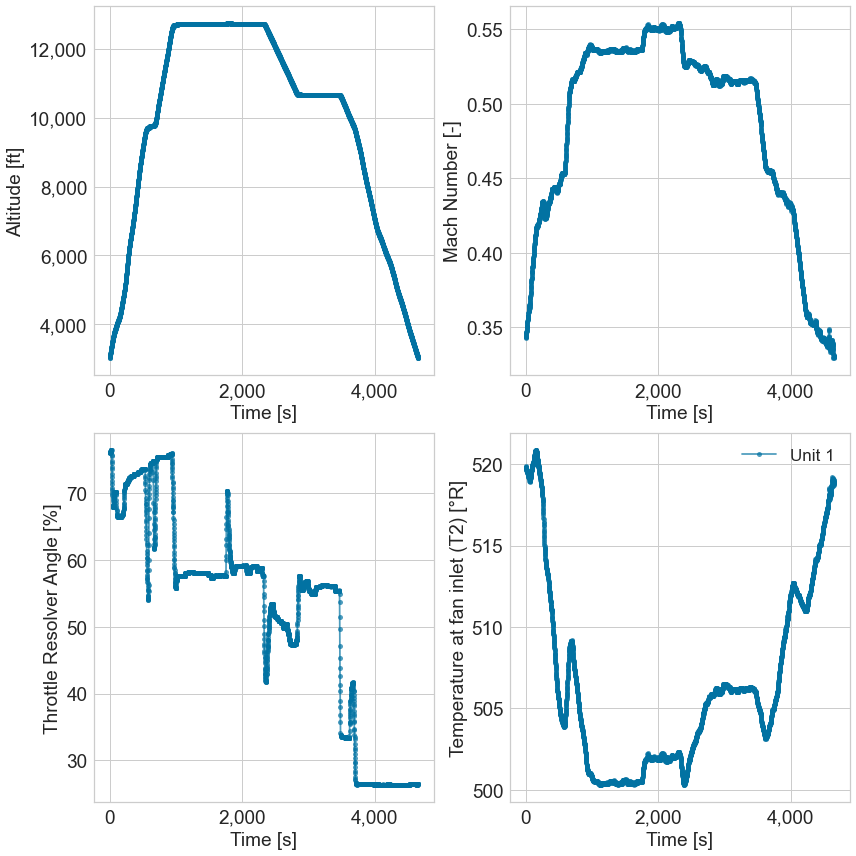

In [9]:
filter1 = df_X_s[df_X_s['unit']==unit]
filter1 = filter1[filter1['cycle']==cycle]
filter1.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(filter1, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'.png')

In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
x = np.array(np.arange(len(df_X_s)))
y = np.array(df_X_s['alt'].to_list())

# calcolare la derivata
dy_dx = np.gradient(y, x)

# trovare i punti stazionari
stationary_points = x[np.where(dy_dx == 0)[0]]

print(stationary_points)

df_X_s = df_X_s.iloc[stationary_points]
df_X_s.reset_index(inplace=True, drop=True)

[   1201    1202    1205 ... 9821802 9821805 9821810]


<Figure size 432x288 with 0 Axes>

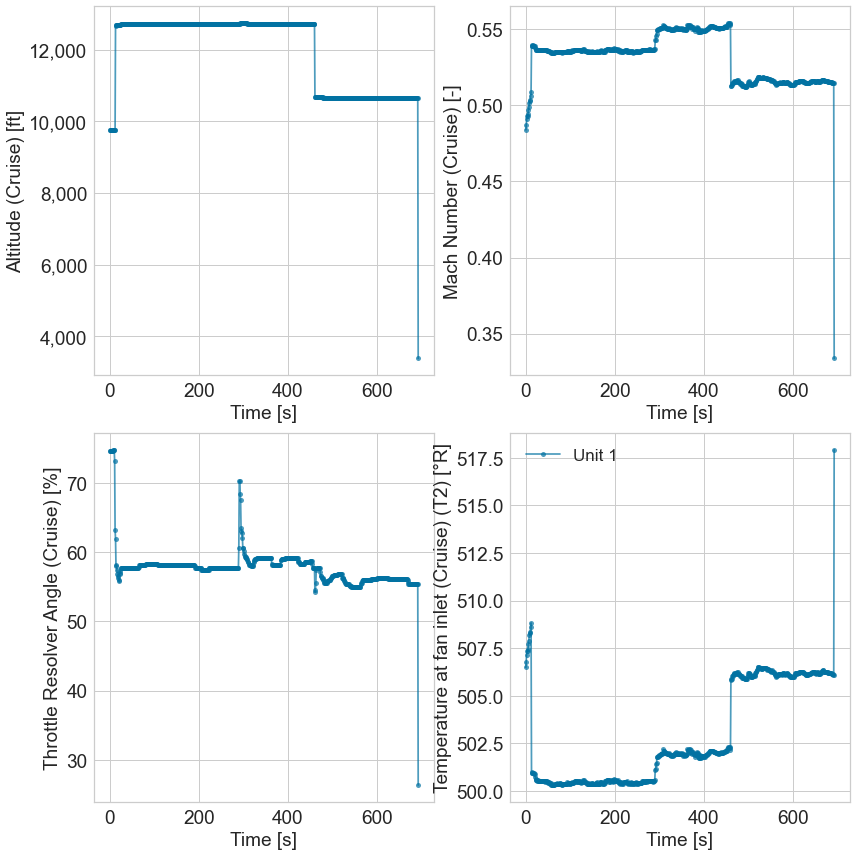

In [11]:
filter2 = df_X_s[df_X_s['unit']==unit]
filter2 = filter2[filter2['cycle']==cycle]
filter2.reset_index(inplace=True, drop=True)
labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
plot_df_color_per_unit(filter2, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

In [ ]:
df_X_s.info(memory_usage="deep")

In [ ]:
df_X_s

In [ ]:
filter3 = df_X_s[df_X_s['unit']==unit]
filter3 = filter3[filter3['cycle']==cycle]
filter3.reset_index(inplace=True, drop=True)
labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
plot_df_color_per_unit(filter3, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

## CLUSTERING

-2.4930439490009e-15 0.9999999999999997
(1206302, 19)


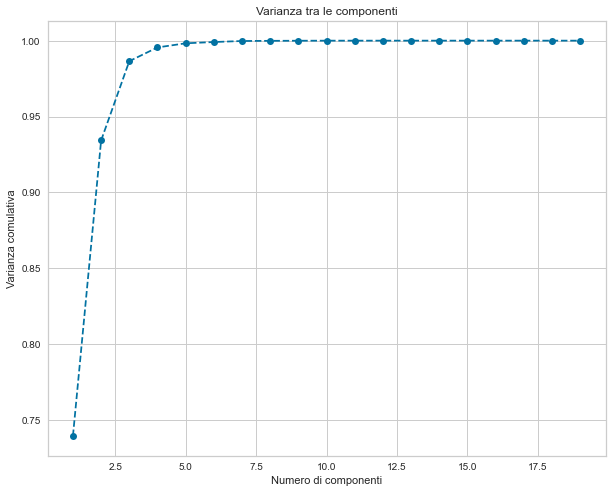

In [12]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit",'cycle']))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 2


KMeans(n_clusters=2, random_state=42)

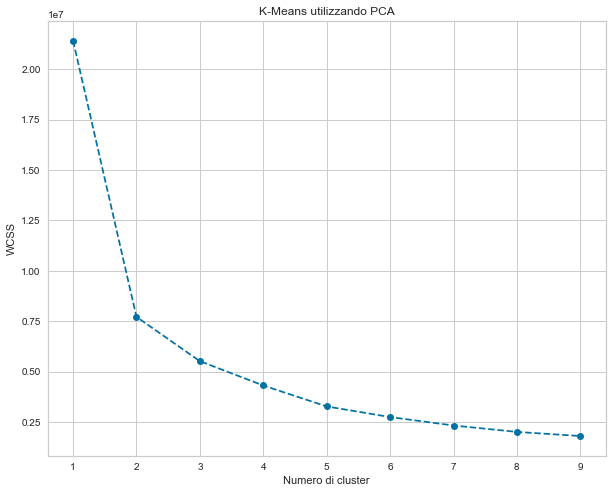

In [13]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
      kmeans_pca.fit(scores_pca)
      wcss.append(kmeans_pca.inertia_)
      print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

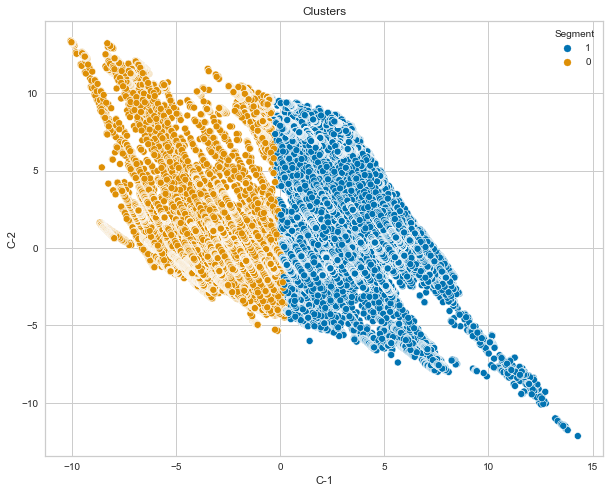

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,unit,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment
0,1201,575.585221,1356.698003,1678.945042,1144.139305,13.202838,10.105286,13.403897,16.447152,252.958566,...,1.0,14728.0,0.526176,64.687042,491.959846,1.0,1.882101,-1.331484,1,1
1,1202,575.617511,1356.729289,1679.015865,1144.175683,13.205239,10.107420,13.406334,16.450322,252.984716,...,1.0,14728.0,0.526491,64.687042,491.989525,1.0,1.884592,-1.333798,1,1
2,1205,577.193962,1364.685513,1695.841339,1152.990245,13.280823,10.110137,13.483070,16.597188,258.201568,...,1.0,14729.0,0.526932,66.532730,492.029196,1.0,2.172831,-1.899382,1,1
3,1210,582.350399,1385.620795,1736.391041,1172.415988,13.516805,10.116658,13.722645,17.072479,271.999280,...,1.0,14733.0,0.528066,71.718239,492.127405,1.0,2.914623,-3.376747,1,1
4,1214,585.008984,1395.995895,1755.333613,1181.259886,13.649547,10.130488,13.857408,17.324534,279.053564,...,1.0,14736.0,0.530208,74.354942,492.325196,1.0,3.285680,-4.097152,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206297,9821800,548.372413,1224.844678,1459.604241,1087.523280,12.869806,10.999711,13.065793,14.885882,183.630439,...,15.0,10733.0,0.409059,29.794710,496.471212,67.0,-0.853178,8.210485,0,0
1206298,9821801,548.210145,1224.927629,1462.857929,1090.331618,12.861951,10.997715,13.057819,14.871845,183.726547,...,15.0,10733.0,0.408744,29.794710,496.445474,67.0,-0.827458,8.176131,0,0
1206299,9821802,548.186983,1224.918853,1461.964237,1089.545751,12.859793,10.994035,13.055628,14.869706,183.720469,...,15.0,10733.0,0.408114,29.794710,496.398006,67.0,-0.836125,8.186632,0,0
1206300,9821805,548.081820,1224.781454,1462.059195,1089.723505,12.851797,10.986055,13.047510,14.859825,183.649764,...,15.0,10732.0,0.406728,29.794710,496.293179,67.0,-0.840716,8.191915,0,0


In [14]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [15]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

2.1829063928724103e-16 1.0
(614649, 21)
-7.998614218511757e-16 0.9999999999999996
(591653, 21)


,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle,group
mean,5.259378e+06,552.043690,1309.93130,1637.521864,1089.994017,9.658490,7.261702,9.805573,12.234275,190.212844,...,2036.456140,8177.829293,2.048172,8.848764,25355.740759,0.664457,72.195028,466.191774,34.980786,0.0
mean,4.740295e+06,580.024365,1347.35379,1651.010361,1154.070706,14.805058,11.694415,15.030516,18.053465,264.090301,...,1933.542346,8296.375178,2.802802,8.098732,10172.467810,0.461482,54.303584,503.625240,36.890410,1.0


Text(0, 0.5, 'Flight Class # [-]')

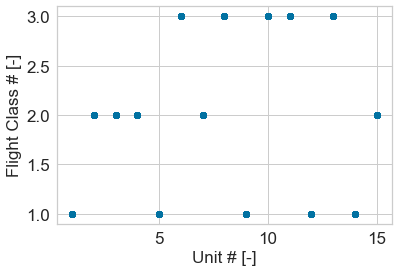

In [16]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [17]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 1,
 2: 2,
 3: 2,
 4: 2,
 5: 1,
 6: 3,
 7: 2,
 8: 3,
 9: 1,
 10: 3,
 11: 3,
 12: 1,
 13: 3,
 14: 1,
 15: 2}

In [18]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment,class
0,1201,575.585221,1356.698003,1678.945042,1144.139305,13.202838,10.105286,13.403897,16.447152,252.958566,...,14728.0,0.526176,64.687042,491.959846,1.0,1.882101,-1.331484,1,1,1
1,1202,575.617511,1356.729289,1679.015865,1144.175683,13.205239,10.107420,13.406334,16.450322,252.984716,...,14728.0,0.526491,64.687042,491.989525,1.0,1.884592,-1.333798,1,1,1
2,1205,577.193962,1364.685513,1695.841339,1152.990245,13.280823,10.110137,13.483070,16.597188,258.201568,...,14729.0,0.526932,66.532730,492.029196,1.0,2.172831,-1.899382,1,1,1
3,1210,582.350399,1385.620795,1736.391041,1172.415988,13.516805,10.116658,13.722645,17.072479,271.999280,...,14733.0,0.528066,71.718239,492.127405,1.0,2.914623,-3.376747,1,1,1
4,1214,585.008984,1395.995895,1755.333613,1181.259886,13.649547,10.130488,13.857408,17.324534,279.053564,...,14736.0,0.530208,74.354942,492.325196,1.0,3.285680,-4.097152,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206297,9821800,548.372413,1224.844678,1459.604241,1087.523280,12.869806,10.999711,13.065793,14.885882,183.630439,...,10733.0,0.409059,29.794710,496.471212,67.0,-0.853178,8.210485,0,0,2
1206298,9821801,548.210145,1224.927629,1462.857929,1090.331618,12.861951,10.997715,13.057819,14.871845,183.726547,...,10733.0,0.408744,29.794710,496.445474,67.0,-0.827458,8.176131,0,0,2
1206299,9821802,548.186983,1224.918853,1461.964237,1089.545751,12.859793,10.994035,13.055628,14.869706,183.720469,...,10733.0,0.408114,29.794710,496.398006,67.0,-0.836125,8.186632,0,0,2
1206300,9821805,548.081820,1224.781454,1462.059195,1089.723505,12.851797,10.986055,13.047510,14.859825,183.649764,...,10732.0,0.406728,29.794710,496.293179,67.0,-0.840716,8.191915,0,0,2


In [19]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       3     448195
1       2     164076
2       1       2378
totale cluster 0 : 614649
cluster 1
   Classe  Conteggio
0       1     213160
1       3     204113
2       2     174380
totale cluster 1 : 591653
cluster 2
Empty DataFrame
Columns: [Classe, Conteggio]
Index: []
totale cluster 2 : 0


In [ ]:
for i in range(0,3):
    filter_cluster = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == i]
    print('Saving Cluster',i)
    filename_out = filename.replace('.h5','')
    filename_out += "_clr_" + str(i) + ".csv"
    filter_cluster.to_csv("../cluster_csv/"+filename_out,index=False)